# This is just a test to see if all environment settings are working

In [33]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import triangulate, polygonize

In [34]:
import momepy as mm
mm.__version__

'0.5.3+1.g3e8395f'

<AxesSubplot:>

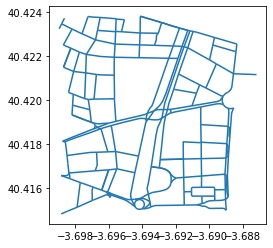

In [35]:
point = 40.41932, -3.69307 #cibeles, Madrid
dist = 500
G = ox.graph_from_point(point, dist=dist, network_type='drive', simplify = True)
nodes, edges = ox.graph_to_gdfs(G)
edges.plot()

In [36]:
#use only the geometry and a basic id as a starting point to homogenize 
edges_minimal = gpd.GeoDataFrame(edges.reset_index()['geometry'])
edges_minimal = edges_minimal.to_crs(2062)

In [ ]:
#storing the first and last points of each edge
#edges_minimal['first'] = edges_minimal.geometry.apply(lambda x : Point(x.coords[0]) )
#edges_minimal['last'] = edges_minimal.geometry.apply(lambda x : Point(x.coords[-1]) )
#edges_minimal.tail()

In [37]:
# polygonize network
# here we need to make sure the outter convex/concave hull is also considered.
polys = list(polygonize(edges_minimal.geometry.to_list()))
crs = edges_minimal.crs
gdf = gpd.GeoDataFrame(geometry=polys, crs=crs)
gdf.reset_index().explore()

# testing averga geometry 

<AxesSubplot:>

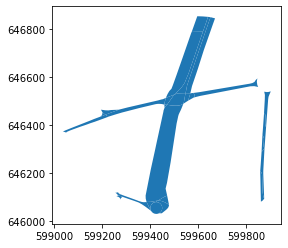

In [6]:
#handpicking the wrong 
ls = [82,72,54,55,80,81,75,76,53,79,18,19,78,77,73,4,7,50,6,17,37,21,52,70,1,0,63,26]
inv_gdf = gdf.iloc[ls]
inv_gdf.plot()

In [32]:
[ g for g in  inv_gdf.geometry.unary_union.geoms]

# overlap with buildings -- TEST ---
intersecting the buildings of the area would leave out the INVALID polygons too

too expensive, but a temporary workaround

In [ ]:
buildings = ox.geometries_from_point(point, tags = {'building': True}, dist= dist)
buildings = buildings.to_crs(gdf.crs)
buildings.plot()

In [ ]:
valid = gpd.sjoin(gdf, buildings, how= 'inner')
valid = valid[['geometry','area']]
valid.index.name = 'index'

valid.plot()

In [ ]:
#exclude also those poligons with low density/footprint
b_footprint =  valid.reset_index().groupby('index')['area'].sum()

In [ ]:
v_series = valid.drop_duplicates(subset = 'geometry')['geometry']
valid  = gpd.GeoDataFrame(b_footprint, geometry = v_series)
valid.tail()

In [ ]:
valid.rename(columns = {'area': 'buildings_ftp'}, inplace=True)
valid['footprint_ratio'] = valid.geometry.area/valid['buildings_ftp']

In [ ]:
valid.head()

In [ ]:
valid.plot('footprint_ratio', figsize = (10,10))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
f, ax = plt.subplots()

valid.plot(ax=ax,column= 'footprint_ratio')
buildings.plot(ax=ax, color='#fff7ff')

plt.show()

In [ ]:
# quick attempots locally in QGIS
edges.to_crs(buildings.crs).to_file('edges.gpkg', driver='GPKG')
buildings.reset_index().loc[:,'element_type':'geometry':1].to_file('buildings.gpkg', driver='GPKG')

# real order of polygonize full 
results, cuts,dangles, invalids